In [1]:
import sys
import os
from datetime import datetime
import json
import shutil
import random
import ast
import numpy as np
import pandas as pd
#import tensorflow as tf
#from tensorflow import keras
from tqdm import tqdm_notebook, tqdm
from matplotlib import pyplot as plt

sys.path.append('../src/')
from env import BTCMarket_Env
from agent import Trader_Agent
from DQNtrainer import DQNTrainer
from DRLtrainer import DRLTrainer
from collections import deque
import h5py
from itertools import product


2023-04-18 12:57:40.566338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(42)
hpo_params= { 
    'obs_space' : [(8,20)], 
    'action_domain' : [(0.0,1.0)], # (-1.0,1.0),
    'money' : [10000], 
    'fee' : [0.001], 
    'asset' : ['BTC'],#, 'PERP'],
#    'reward_function' : ['compute_reward_from_tutor', 'reward_sharpe_ratio', 'reward_sortino_ratio', 
#                        'reward_differential_sharpe_ratio', 'reward_sterling_ratio'],
    'reward_function' : ['reward_differential_sharpe_ratio'],
    
    'learning_rate': [1e-5],
    'trainer' : ['DRLTrainer'], # 'DRLTrainer', 'DQNTrainer'
    'episodes' : [1], 
    'runs_p_eps' : [2], 
    'batch_size': [1],
    'epoch': [5],
    'gamma': [0.95],
    
    'epsilon': [0.01],
    'epsilon_final':[0.01],
    'epsilon_decay':[0.7],
}


keys, values = zip(*hpo_params.items())
hpo_list = [dict(zip(keys, v)) for v in product(*values)]
print(hpo_list)

[{'obs_space': (8, 20), 'action_domain': (0.0, 1.0), 'money': 10000, 'fee': 0.001, 'asset': 'BTC', 'reward_function': 'reward_differential_sharpe_ratio', 'learning_rate': 1e-05, 'trainer': 'DRLTrainer', 'episodes': 1, 'runs_p_eps': 2, 'batch_size': 1, 'epoch': 5, 'gamma': 0.95, 'epsilon': 0.01, 'epsilon_final': 0.01, 'epsilon_decay': 0.7}]


In [3]:
with open('/Users/samuelharck/Desktop/Projekt/ai_trader/data/20230412_163929/DRL_trial_0/params.json') as fd:
    train = json.load(fd)
print(train)

{'obs_space': [8, 20], 'action_domain': [0.0, 1.0], 'money': 10000, 'fee': 0.001, 'asset': 'BTC', 'reward_function': 'reward_differential_sharpe_ratio', 'learning_rate': 0.001, 'trainer': 'DRLTrainer', 'episodes': 1, 'runs_p_eps': 1, 'batch_size': 1, 'epoch': 5, 'gamma': 0.95, 'epsilon': 0.7, 'epsilon_final': 0.01, 'epsilon_decay': 0.995, 'action_space': 1, 'algorithm': 'DRL_trial_0'}


In [ ]:
with open('/Users/samuelharck/Desktop/Projekt/ai_trader/data/20230418_095301/DRL_trial_0/params.json') as fd:
    tmp = json.load(fd)
print(tmp)
dfnew = pd.read_csv(f'/Users/samuelharck/Desktop/Projekt/ai_trader/data/20230418_095301/DRL_trial_0/Epi_1_run_1.csv')

In [ ]:
with open('/Users/samuelharck/Desktop/Projekt/ai_trader/results/20230406_073724/DRL_trial/params.json') as fd:
    tmp = json.load(fd)
print(tmp)
dfold = pd.read_csv('/Users/samuelharck/Desktop/Projekt/ai_trader/results/20230406_073724/DRL_trial/episodes/Epi_1_run_1_BTC.csv')

In [3]:
i = 0
#for i, param_combination in enumerate(hpo_list):
param_combination = hpo_list[0]
if param_combination.get('trainer') == 'DQNTrainer':
    action_space = 4
    algorithm = f'DQN_trial_{i}'
else:
    action_space = 1
    algorithm = f'DRL_trial_{i}'
    
param_combination['action_space'] = action_space
param_combination['algorithm'] = algorithm
print(param_combination)

env = BTCMarket_Env(observation_space = param_combination.get('obs_space', (8,20)),
        action_space = action_space,
        start_money = param_combination.get('money', 10000),
        trading_fee = param_combination.get('fee', (8,20)),
        asset = param_combination.get('asset', 'PERP'),
        reward_function = param_combination.get('reward_function', 'reward_differential_sharpe_ratio'),
                   )

agent = Trader_Agent(observation_space = param_combination.get('obs_space', (8,20)),
            action_space = action_space,
            action_domain=param_combination.get('action_domain', (0.0,1.0)),
            epsilon = param_combination.get('epsilon', 0.7),
            epsilon_final = param_combination.get('epsilon_final', 0.01),
            epsilon_decay = param_combination.get('epsilon_decay', 0.995),
                    )

trainer_class = eval(param_combination.get('trainer', 'DRLTrainer'))
trainer = trainer_class(env, agent,
            observation_space = param_combination.get('obs_space', (8,20)),
            action_space = action_space,
            batch_size=param_combination.get('batch_size', 50),
            epoch=param_combination.get('epoch', 5),
            gamma=param_combination.get('gamma', 0.95),
            learning_rate=param_combination.get('learning_rate', 1e-3),
            algorithm=algorithm,
            lstm_path="./../notebooks/best_models/11_mar_2023/best_model_sequential_20back_10ahead.h5",
            # best_model_sequential_20back_10ahead lstm_2,
                       )

os.makedirs(trainer.train_folder,exist_ok=True)
with open(f'{trainer.train_folder}/params.json', 'w') as fp:
    json.dump(param_combination, fp)
    
trainer.rollout(n_episodes=param_combination.get('episodes', 2), 
                   run_per_episode=param_combination.get('runs_p_eps', 2))

{'obs_space': (8, 20), 'action_domain': (0.0, 1.0), 'money': 10000, 'fee': 0.001, 'asset': 'BTC', 'reward_function': 'reward_differential_sharpe_ratio', 'learning_rate': 1e-05, 'trainer': 'DRLTrainer', 'episodes': 1, 'runs_p_eps': 2, 'batch_size': 1, 'epoch': 5, 'gamma': 0.95, 'epsilon': 0.01, 'epsilon_final': 0.01, 'epsilon_decay': 0.7, 'action_space': 1, 'algorithm': 'DRL_trial_0'}


2023-04-18 12:57:45.851301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 8)]      0           []                               
                                                                                                  
 lstm_inputs (Lambda)           (None, 20, 4)        0           ['input_1[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 10)           1953940     ['lstm_inputs[0][0]']            
                                                                                                  
 flatten_1 (Flatten)            (None, 10)           0           ['sequential[0][0]']             
                                                                                              

  0%|          | 1/671 [00:01<12:52,  1.15s/it]

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 2.3777e-04
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 2.3722e-04
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 2.3662e-04
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 2.3598e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 2.3532e-04


  0%|          | 2/671 [00:04<26:17,  2.36s/it]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 2.4315e-04
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 2.4266e-04
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 2.4214e-04
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 2.4161e-04
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 2.4108e-04


  1%|          | 4/671 [00:04<10:25,  1.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 3.2644e-04
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 3.2567e-04
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 3.2484e-04
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 3.2398e-04
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 3.2309e-04


  1%|          | 6/671 [00:04<05:56,  1.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 5.3468e-04
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 5.3303e-04
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 5.3122e-04
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 5.2929e-04
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 5.2728e-04


  1%|          | 8/671 [00:04<03:51,  2.86it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 8.0880e-04
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 8.0635e-04
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 8.0366e-04
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 8.0079e-04
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 7.9779e-04


  1%|▏         | 10/671 [00:05<02:47,  3.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 7.8558e-04
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 7.8327e-04
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 7.8078e-04
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 7.7814e-04
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 7.7539e-04


  2%|▏         | 12/671 [00:05<02:09,  5.07it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 8.7067e-04
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 8.6788e-04
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 8.6473e-04
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 8.6132e-04
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 8.5771e-04


  2%|▏         | 14/671 [00:05<01:49,  6.03it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 9.6303e-04
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 9.5986e-04
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 9.5641e-04
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 9.5268e-04
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 9.4875e-04


  2%|▏         | 16/671 [00:05<01:36,  6.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 9.4593e-04
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 9.4235e-04
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 9.3846e-04
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 9.3433e-04
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 9.3002e-04


  3%|▎         | 18/671 [00:05<01:24,  7.73it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 8.4946e-04
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 8.4576e-04
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 8.4170e-04
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 8.3737e-04
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 8.3284e-04


  3%|▎         | 20/671 [00:05<01:16,  8.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0010


  3%|▎         | 22/671 [00:06<01:12,  8.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0010
Epoch 4/5
1/1 [==============================] - 0s 22ms/step - loss: 0.0010
Epoch 5/5
1/1 [==============================] - 0s 17ms/step - loss: 0.0010


  4%|▎         | 24/671 [00:06<01:13,  8.78it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0010
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 9.9726e-04


  4%|▍         | 26/671 [00:06<01:09,  9.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 9.9781e-04


  4%|▍         | 28/671 [00:06<01:08,  9.39it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0010


  4%|▍         | 30/671 [00:07<01:06,  9.66it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0011


  5%|▍         | 32/671 [00:07<01:03, 10.10it/s]

Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0011


  5%|▌         | 34/671 [00:07<01:00, 10.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.0012


  5%|▌         | 36/671 [00:07<00:58, 10.94it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011


  6%|▌         | 38/671 [00:07<00:57, 10.96it/s]

Epoch 1/5
1/1 [==============================] - 0s 15ms/step - loss: 0.0011
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 4/5
1/1 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 0.0011


  6%|▌         | 40/671 [00:07<01:02, 10.16it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0013
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0013
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0013
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0013
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0013


  6%|▋         | 42/671 [00:08<01:05,  9.60it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010


  7%|▋         | 44/671 [00:08<01:04,  9.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011


  7%|▋         | 46/671 [00:08<01:04,  9.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0011


  7%|▋         | 48/671 [00:08<01:03,  9.84it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0012
Epoch 3/5
1/1 [==============================] - 0s 15ms/step - loss: 0.0011
Epoch 4/5
1/1 [==============================] - 0s 13ms/step - loss: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 13ms/step - loss: 0.0011


  7%|▋         | 50/671 [00:08<01:02,  9.93it/s]

Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 4/5
1/1 [==============================] - 0s 15ms/step - loss: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011


  8%|▊         | 52/671 [00:09<01:02,  9.92it/s]

Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 9.2989e-04
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 9.2374e-04
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 9.1721e-04
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 9.1040e-04
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 9.0335e-04


  8%|▊         | 54/671 [00:09<01:03,  9.69it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 0.0010
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010


  8%|▊         | 56/671 [00:09<01:03,  9.65it/s]

Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010


  9%|▊         | 58/671 [00:09<01:02,  9.77it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 9.2609e-04
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 9.2088e-04
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 9.1516e-04
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 9.0904e-04
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 9.0261e-04


  9%|▉         | 60/671 [00:10<01:01,  9.97it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0013


  9%|▉         | 62/671 [00:10<00:59, 10.22it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0011


 10%|▉         | 64/671 [00:10<00:58, 10.41it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0010


 10%|▉         | 66/671 [00:10<00:57, 10.56it/s]

Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 0.0012


 10%|█         | 69/671 [00:10<01:34,  6.37it/s]


KeyboardInterrupt: 

In [36]:
# Plot profit
dfnn = pd.read_csv(f'/Users/samuelharck/Desktop/Projekt/ai_trader/data/20230418_122912/DRL_trial_0/Epi_1_run_5.csv')
#df = pd.read_csv(f'{trainer.train_folder}/Trainer_Data.csv')
print(dfnn.shape)
#print(max(df.time_elapsed))

(670, 24)


In [37]:
dfac = dfnn.action
dfac.tail(25)

645    [0.]
646    [0.]
647    [0.]
648    [0.]
649    [0.]
650    [0.]
651    [0.]
652    [0.]
653    [0.]
654    [0.]
655    [0.]
656    [0.]
657    [0.]
658    [0.]
659    [0.]
660    [0.]
661    [0.]
662    [0.]
663    [0.]
664    [0.]
665    [0.]
666    [0.]
667    [0.]
668    [0.]
669    [0.]
Name: action, dtype: object

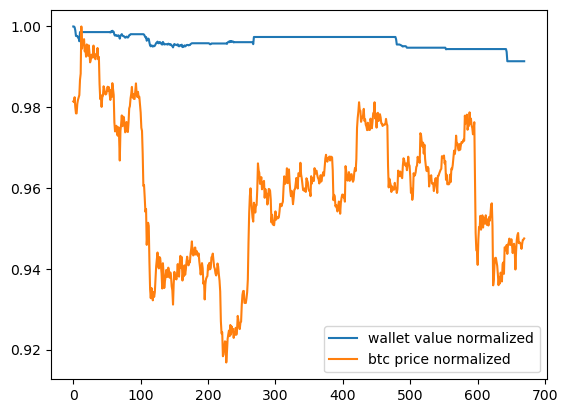

In [38]:
#tmp1 = [ast.literal_eval(n) for n in dfnn["wallet_value"]]
wallet = dfnn["wallet_value"].to_numpy()
wallet = wallet / np.max(wallet)
price = dfnn["btc_price"].to_numpy()
price = price / np.max(price)
plt.plot(wallet, label='wallet value normalized')
plt.plot(price, label='btc price normalized')
#tmp2 = [ast.literal_eval(n) for n in dfold["action"]]
#plt.plot(tmp2, label='old')
plt.legend()

In [39]:
dfnn.keys()

Index(['Unnamed: 0', 'action', 'short_wallet', 'short_eur', 'funding_rate',
       'buy_short_count', 'short_units', 'reward', 'wallet_value', 'btc_price',
       'state', 'sell_long_count', 'btc_units', 'done', 'btc_eur', 'episode',
       'long_wallet', 'short_position', 'money', 'sell_short_count',
       'fee_paid', 'buy_long_count', 'swap_price', 'long_position'],
      dtype='object')

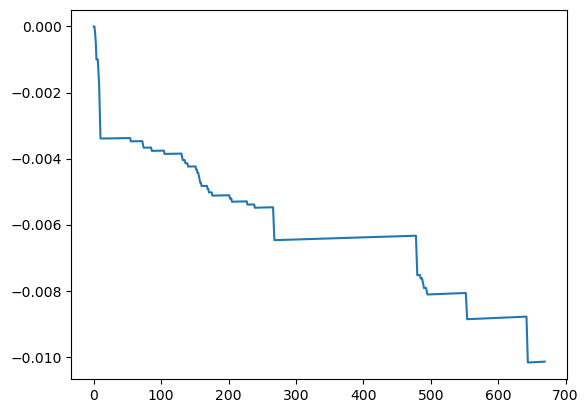

In [40]:
y = [ast.literal_eval(x)[0] for x  in dfnn.reward]
plt.plot(y)

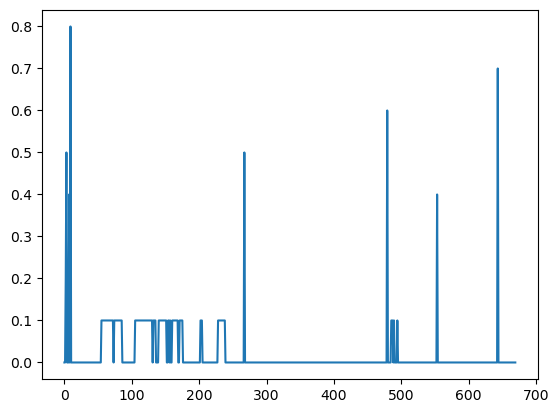

In [41]:
y = [ast.literal_eval(x)[0] for x  in dfnn.action]
plt.plot(y)

In [ ]:
dfep = pd.read_csv(f'/Users/samuelharck/Desktop/Projekt/ai_trader/data/20230412_163929/DRL_trial_0/Epi_1_run_1.csv')

In [ ]:
print(dfep.columns)
dfep.tail(10)


In [ ]:
plt.plot(dfep.wallet_value, label='wallet value')
plt.plot(dfep.btc_price, label='btc price')
plt.legend()

In [ ]:
tmp1 = [ast.literal_eval(n) for n in dfnn["wallet_value"]]
plt.plot(tmp1, label='new')
#tmp2 = [ast.literal_eval(n) for n in dfold["action"]]
#plt.plot(tmp2, label='old')
plt.legend()

In [ ]:
plt.plot(dfep.action.to_numpy(), label='action')
#plt.plot(dfep.btc_price, label='btc price')
plt.legend()

In [ ]:
df = pd.read_csv(f'/Users/samuelharck/Desktop/Projekt/ai_trader/data/20230412_163929/DRL_trial_0/Trainer_Data.csv')

In [ ]:
import ast
tmp = [ast.literal_eval(n) for n in df["action"]]

plt.plot(tmp, label='action')
#plt.plot(dfep.btc_price, label='btc price')
plt.legend()